In [58]:
%matplotlib inline
import future
import pylab as plt
import numpy as np
from bornagain import Molecule
from scipy.spatial import distance
from bornagain.simulate import refdata

In [59]:
from loki.utils.postproc_helper import is_outlier

def single_atom_dens(atomic_num, grid_size=3, grid_spacing=0.05,
                    filter_atomic_core=True, filter_thresh=50, 
                    filter_sig=5):
    """
    atomic_num, atomic number of element 
    grid_size, size of cubic density grid in Angstrom
    grid_spacing, spacing of cubic grid in Angstrom
    filter_atomic_core, whether to filter the faulty density at atomic core
    """
    #print atomic_num
    Ngrid_pt = int( float(grid_size)/grid_spacing)

    vals = np.arange( -Ngrid_pt/2, Ngrid_pt/2)  * grid_spacing #, grid_spacing)
    
    x,y,z = np.meshgrid( vals,vals,vals, sparse=True)
    R = np.sqrt( x**2 + y**2 + z**2 )
    R1 = R.ravel()

    rho = np.zeros( R1.shape).astype(np.float32)
    
    # this bit makes the form factor
    cromermann = refdata.get_cromermann_parameters( [atomic_num])[atomic_num]
    xo = 4.0 * (np.pi ** 2) * np.power( R1 , 2)
    for i in range(4):    
        rho += cromermann[i] * np.exp(-xo/cromermann[i+4])\
            / np.power(cromermann[i+4], 0.5 )
    
    rho *=  2 * np.sqrt(2) * np.pi

    if filter_atomic_core:
        dm = rho[ rho > 0].mean()
        s = rho [ rho > 0].std()

        idx = np.where( rho > dm+filter_sig*s)[0]
        vals = rho[ idx]
        bad = is_outlier( vals, filter_thresh)
        fillvalue = vals[~bad].max()
        bad_idx3 = idx[bad]
        rho[ bad_idx3] = fillvalue
        print ("Atom %d, replacing %d densities"%(atomic_num, sum(bad)))

    rho = rho.reshape( (Ngrid_pt, Ngrid_pt, Ngrid_pt))
    
    return rho


In [60]:
# make a plot of the atomic densities to test them
grid_param = {'grid_spacing':0.3,'grid_size':6, 
                'filter_thresh':1000, 
              'filter_sig':0, 'filter_atomic_core':True}

In [61]:
# this is the molecule loading
mol = Molecule("2LYZ.pdb")
atom_vecs = mol.atom_vecs*1e10
atomic_nums = mol.Z
atom_vecs -= atom_vecs.mean(0)

unique_atoms = np.unique(atomic_nums )
unique_atom_dens = {n:single_atom_dens(n, grid_size=4, 
                        grid_spacing=0.2, filter_thresh=1000, 
                        filter_atomic_core=True, filter_sig=0) 
                for n in unique_atoms}

pdb_size = distance.pdist( atom_vecs).max()
print pdb_size
res = grid_param['grid_spacing']
grid_size = int( pdb_size*1.5)
print grid_size
Npt = int(float(grid_size)/res)
vals = np.arange( -Npt/2,Npt/2)*res
n = unique_atom_dens[ unique_atom_dens.keys()[0]].shape[0]
print len(atom_vecs)

Atom 6, replacing 0 densities
Atom 7, replacing 1 densities
Atom 8, replacing 0 densities
Atom 16, replacing 0 densities
50.552673213194176
75
1102


In [62]:
# map the molecule to the grid
import sys
dens = np.zeros( (Npt,Npt,Npt), dtype=np.float32)
for atom_i,(a,Z) in enumerate(zip( atom_vecs, atomic_nums)):
    sys.stdout.flush()
    grid_pt = np.floor( ( a - vals[0]) / res).astype(int)
    pts = tuple( [ np.arange( x-n/2, x+n/2).astype(np.int32) for x in grid_pt])
    x,y,z = np.meshgrid( *pts)
    coors =  (x.ravel(), y.ravel(), z.ravel())

    dens[coors] += unique_atom_dens[Z].ravel()
    nn = len( atomic_nums) - atom_i
    print "\r atoms left: %4d"%(nn-1),
    

 atoms left:    0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

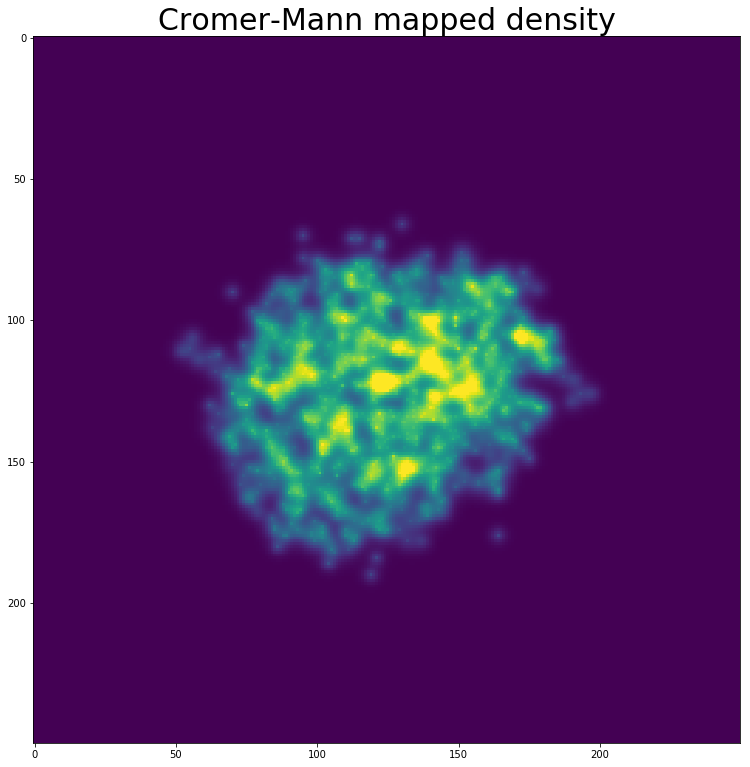

In [63]:
plt.figure(figsize=(13,13))
_=plt.title("Cromer-Mann mapped density", fontsize=30)
_=plt.imshow( dens.mean(0), vmax=2)


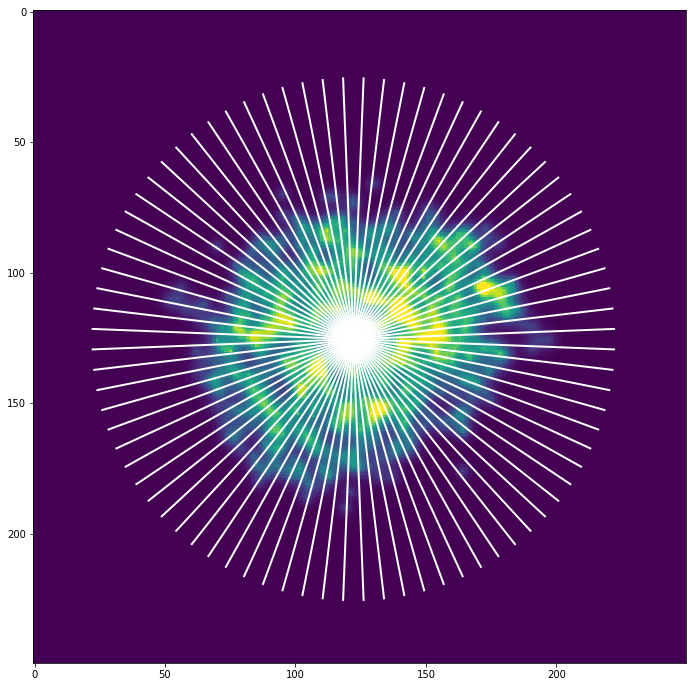

In [64]:
# lets try to determine a boundary in 2D first!
dens2 = dens.mean(0)

# lets locate the center of the density
y,x = np.where( dens2 > 0)

# center of density
y_cent, x_cent = y.mean(), x.mean()
plt.figure(figsize=(12,12))
plt.imshow( dens2, vmax=2)
_=plt.plot( x_cent, y_cent, 'wo', ms=20, mec='r')

# pick some vectors pointing out from center
Nphi = 80
phi_bin = np.linspace( 0,2*np.pi, Nphi+1) - np.pi
phis = phi_bin[1:]*.5 + phi_bin[:-1]*.5
vecs =  np.array( [ [x_cent+100*np.cos(phi), y_cent+100*np.sin(phi)] 
                       for phi in phis] ) 
for v in vecs:
    plt.plot( [v[0] , x_cent], [v[1], y_cent], lw=2, color='w')

In [65]:
# Determine PHI and Radius of each non-zero density

Y,X = np.indices( dens2.shape)
R = np.sqrt( (Y-y_cent)**2 + (X-x_cent)**2) .ravel()
PHI = np.arctan2(Y-y_cent, X-x_cent ).ravel()

has_density = dens2.ravel() > 0

solvent_shell_thickness = 6 # from jochen hub paper
phi_spacing = (phi_bin[1] - phi_bin[0] ) *0.3
bounding_coors = []
bounding_coors0 = []
for phi in phis:
    phi1 = phi - phi_spacing*.5
    phi2 = phi + phi_spacing*.5
    close_to_phi = np.logical_and( PHI > phi1, PHI < phi2)
    valid_pt = np.logical_and( close_to_phi, has_density  )
    
    idx_of_pt = np.where( valid_pt)[0]
    assert( idx_of_pt.size)
    
    r_of_pt = R[idx_of_pt]
    
    rmax_loc =  idx_of_pt[ np.argmax( r_of_pt) ]
    
    #coor = np.unravel_index( rmax_loc, dens2.shape)
    
    phi_bound = phi #PHI[rmax_loc]
    R_bound = R[rmax_loc] + solvent_shell_thickness
    
    coorX = np.cos( phi_bound)*R_bound + x_cent
    coorY = np.sin( phi_bound)*R_bound + y_cent
    coor = coorY, coorX
    
    coorX0 = np.cos( phi_bound)*R[rmax_loc] + x_cent
    coorY0 = np.sin( phi_bound)*R[rmax_loc] + y_cent
    coor0 = coorY0, coorX0
    
    bounding_coors.append( coor)
    bounding_coors0.append( coor0)
    

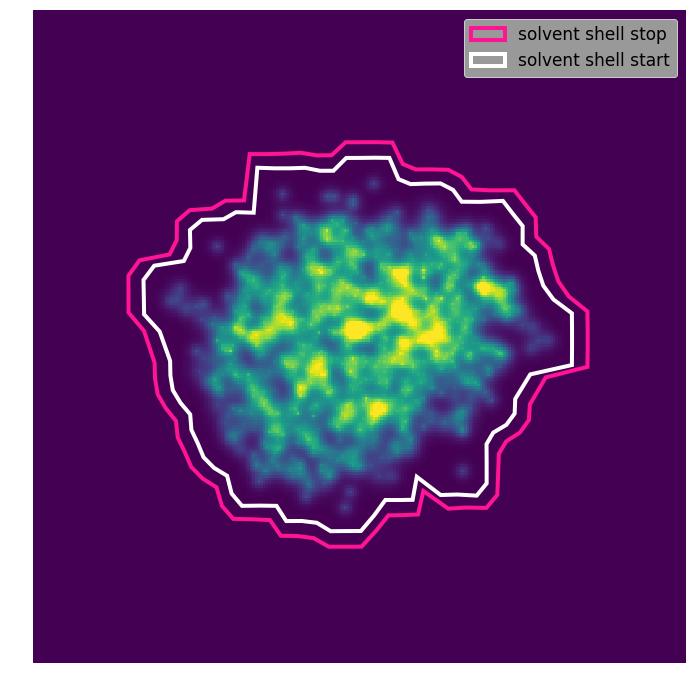

In [66]:
plt.figure(figsize=(12,12))
plt.imshow( dens2, vmax=2)

y_bound,x_bound = map( np.array, zip( * bounding_coors ))
y_bound0,x_bound0 = map( np.array, zip( * bounding_coors0 ))


path = plt.mpl.path.Path( zip( x_bound, y_bound), closed=True) 
patch = plt.mpl.patches.PathPatch(path, facecolor='none', ec='Deeppink', lw=4)
path0 = plt.mpl.path.Path( zip( x_bound0, y_bound0), closed=True) 
patch0 = plt.mpl.patches.PathPatch(path0, facecolor='none', ec='w', lw=4)

_=plt.gca().add_patch( patch)
_=plt.gca().add_patch( patch0)
leg = plt.legend(["solvent shell stop", "solvent shell start"], prop={'size':17 })
fr = leg.get_frame()
fr.set_alpha(1)
fr.set_facecolor("#999999")
_=plt.gca().axis("off")


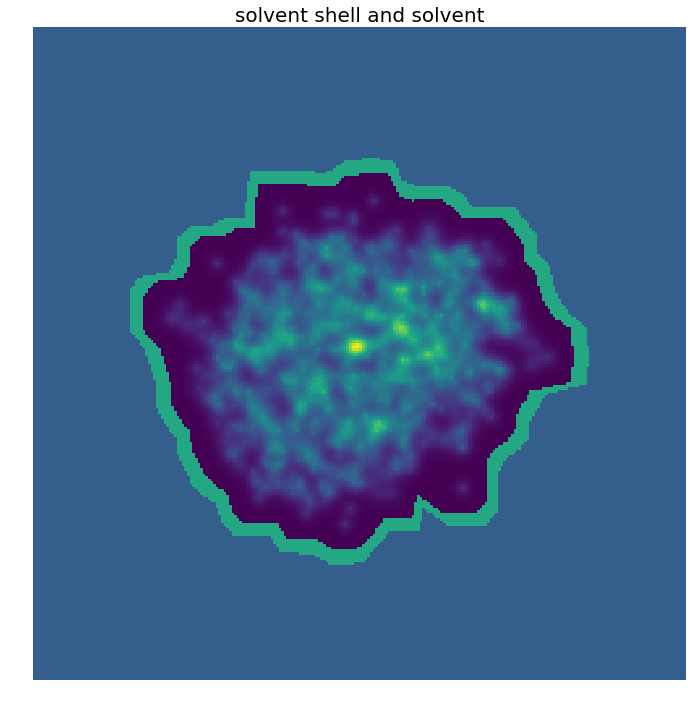

In [67]:
solvent_density = 1
solvent_shell_density =2 

pts = np.array( zip( Y.ravel(), X.ravel() ) )

in_path0 = path0.contains_points( pts)
in_path = path.contains_points( pts)

is_solvent_shell = np.logical_and( in_path, ~in_path0)
is_solvent = ~in_path

xx,yy =  map(np.array, zip( *pts[ is_solvent] ))
xx_shell,yy_shell =  map(np.array, zip( *pts[ is_solvent_shell] ))

idx_solvent = ( yy,xx)
idx_solvent_shell = (yy_shell, xx_shell)

dens2_w_solv = dens2.copy()

dens2_w_solv[ idx_solvent] = solvent_density
dens2_w_solv[ idx_solvent_shell] = solvent_shell_density
plt.figure(figsize=(12,12))
_=plt.imshow( dens2_w_solv)
_ = plt.gca().axis("off")

_ = plt.title("solvent shell and solvent", fontsize=20)

